In [2]:
import os
import glob
import json
import shutil
import h5py
import sys
import time
from IPython.display import display

import torch

sys.path.insert(0, '..')
from attention_corr_methods import custom_load_attentions

import warnings
warnings.filterwarnings(action='once')

In [36]:
!mkdir ../results/LTH-base/val_attns/
!mkdir ../results/LTH-base/val_attns/encenc/
!mkdir ../results/LTH-base/val_attns/encdec/
!mkdir ../results/LTH-base/val_attns/decdec/

In [26]:
# Set arguments to load reps
limit = 10000
model_count = 9
lth_iters = range(model_count)
reps_dir = '/raj-learn/data/precomputed_attns'
encenc_attn_fname_l = sorted(glob.glob(f'{reps_dir}/LTH*/encenc*.hdf5'))
encdec_attn_fname_l = sorted(glob.glob(f'{reps_dir}/LTH*/encdec*.hdf5'))
decdec_attn_fname_l = sorted(glob.glob(f'{reps_dir}/LTH*/decdec*.hdf5'))
device = 'cuda'

In [49]:
%%time
encenc_num_heads_d, encenc_attns_d = custom_load_attentions(encenc_attn_fname_l,
                                                     limit=limit)
encdec_num_heads_d, encdec_attns_d = custom_load_attentions(encdec_attn_fname_l,
                                                     limit=limit)
decdec_num_heads_d, decdec_attns_d = custom_load_attentions(decdec_attn_fname_l,
                                                     limit=limit)

load: 9it [00:12,  1.33s/it]
load: 9it [00:10,  1.21s/it]
load: 9it [00:11,  1.30s/it]

CPU times: user 27.2 s, sys: 4.99 s, total: 32.2 s
Wall time: 34.5 s


In [52]:
%%time
import attention_corr_methods
import importlib
importlib.reload(attention_corr_methods)
from attention_corr_methods import PearsonMaxCorr, PearsonMaxCorr2, JSMaxCorr, AttnLinCKA, AttnCCA

attns = [(encenc_num_heads_d, encenc_attns_d), 
         (encdec_num_heads_d, encdec_attns_d), 
         (decdec_num_heads_d, decdec_attns_d)]
attntypes = ['encenc', 'encdec', 'decdec']
for (i, attntype) in enumerate(attntypes):
    output_dir = f'../results/LTH-base/val_attns/{attntype}/'
    pearsonmaxcorr = PearsonMaxCorr(attns[i][0], attns[i][1], device)
    pearsonmaxcorr2 = PearsonMaxCorr2(attns[i][0], attns[i][1], device)
    jsmaxcorr = JSMaxCorr(attns[i][0], attns[i][1], device)
    lincka = AttnLinCKA(attns[i][0], attns[i][1], device)
#     cca = AttnCCA(num_heads_d, attns[i].copy(), device)
    for corr_method in [pearsonmaxcorr, pearsonmaxcorr2, jsmaxcorr, lincka]:
        t0 = time.time()
        corr_method.compute_correlations()
        corr_method.write_correlations(output_dir + str(corr_method))
        print('%s, %s took %.2fsec' % (str(corr_method), attntype, time.time() - t0))

correlate:   0%|          | 0/2916 [00:00<?, ?it/s]

pearsonmaxcorr, encenc took 198.95sec


correlate:   0%|          | 0/2916 [00:00<?, ?it/s]

pearsonmaxcorr2, encenc took 404.96sec


lincka:   0%|          | 0/2916 [00:00<?, ?it/s]

jsmaxcorr, encenc took 482.50sec


lincka: 100%|██████████| 2916/2916 [00:01<00:00, 2339.13it/s]


attn_lincka, encenc took 1.36sec


correlate:   0%|          | 0/2916 [00:00<?, ?it/s]

pearsonmaxcorr, encdec took 204.07sec


correlate:   0%|          | 0/2916 [00:00<?, ?it/s]

pearsonmaxcorr2, encdec took 381.31sec


mu, sigma:   6%|▌         | 3/54 [00:00<00:01, 28.38it/s]

jsmaxcorr, encdec took 437.26sec


lincka: 100%|██████████| 2916/2916 [00:11<00:00, 263.38it/s]


attn_lincka, encdec took 13.44sec


correlate:   0%|          | 0/2916 [00:00<?, ?it/s]

pearsonmaxcorr, decdec took 203.99sec


correlate:   0%|          | 0/2916 [00:00<?, ?it/s]

pearsonmaxcorr2, decdec took 389.76sec


lincka:   0%|          | 1/2916 [00:00<00:05, 535.47it/s]

jsmaxcorr, decdec took 603.48sec


ZeroDivisionError: float division by zero

In [56]:
!ls ../results/LTH-base/val_attns/encenc

attn_lincka  jsmaxcorr	pearsonmaxcorr	pearsonmaxcorr2


In [125]:
%%time
import pickle

results_dir = '../results/LTH-base/val_attns'
res_dict = {'encenc' : {}, 'encdec' : {}, 'decdec' : {}}
for attntype in res_dict.keys():
    res_fname = {method: f'{results_dir}/{attntype}/{method}' for method in 
                ["pearsonmaxcorr", "pearsonmaxcorr2", "jsmaxcorr", "attn_lincka"]}
    res_dict[attntype]["pearsonmaxcorr"] = pickle.load(open(res_fname["pearsonmaxcorr"], "rb"))
    res_dict[attntype]["pearsonmaxcorr2"] = pickle.load(open(res_fname["pearsonmaxcorr2"], "rb"))
    res_dict[attntype]["jsmaxcorr"] = pickle.load(open(res_fname["jsmaxcorr"], "rb"))
    if attntype != 'decdec':
        res_dict[attntype]["lincka"] = pickle.load(open(res_fname["attn_lincka"], "rb"))

/raj-learn/lth/lib/python3.6/site-packages/ipykernel_launcher.py:9: ResourceWarning: unclosed file <_io.BufferedReader name='../results/LTH-base/val_attns/encenc/pearsonmaxcorr'>
  if __name__ == '__main__':
/raj-learn/lth/lib/python3.6/site-packages/ipykernel_launcher.py:10: ResourceWarning: unclosed file <_io.BufferedReader name='../results/LTH-base/val_attns/encenc/pearsonmaxcorr2'>
  # Remove the CWD from sys.path while we load stuff.
/raj-learn/lth/lib/python3.6/site-packages/ipykernel_launcher.py:11: ResourceWarning: unclosed file <_io.BufferedReader name='../results/LTH-base/val_attns/encenc/jsmaxcorr'>
  # This is added back by InteractiveShellApp.init_path()
/raj-learn/lth/lib/python3.6/site-packages/ipykernel_launcher.py:13: ResourceWarning: unclosed file <_io.BufferedReader name='../results/LTH-base/val_attns/encenc/attn_lincka'>
  del sys.path[0]
/raj-learn/lth/lib/python3.6/site-packages/ipykernel_launcher.py:9: ResourceWarning: unclosed file <_io.BufferedReader name='../r

CPU times: user 671 ms, sys: 96.4 ms, total: 768 ms
Wall time: 775 ms


/raj-learn/lth/lib/python3.6/site-packages/ipykernel_launcher.py:10: ResourceWarning: unclosed file <_io.BufferedReader name='../results/LTH-base/val_attns/decdec/pearsonmaxcorr2'>
  # Remove the CWD from sys.path while we load stuff.
/raj-learn/lth/lib/python3.6/site-packages/ipykernel_launcher.py:11: ResourceWarning: unclosed file <_io.BufferedReader name='../results/LTH-base/val_attns/decdec/jsmaxcorr'>
  # This is added back by InteractiveShellApp.init_path()


In [127]:
def fix_layername(layer):
    return layer.split('_')[0] + '-layer' + str(int(layer.split('_')[-1])+1)

attnsim = {attntype : {key : {} for key in res_dict[attntype]} for attntype in res_dict}
for attntype in attnsim:
    for simtype in attnsim[attntype]:
        layer_names = list(res_dict[attntype]['pearsonmaxcorr']['similarities'].keys())
        for layer in layer_names:
            attnsim[attntype][simtype][fix_layername(layer)] = {fix_layername(layer) : 1.0}
            similarities = res_dict[attntype][simtype]['similarities'][layer]
            for other_layer in similarities:
                attnsim[attntype][simtype][fix_layername(layer)][fix_layername(other_layer)] = similarities[other_layer]

### Plot

In [128]:
%%time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Rectangle
from matplotlib import rcParams
from matplotlib import font_manager
fpath = '/raj-learn/envs/contextual_repr_analysis/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/cmss10.ttf'
prop = font_manager.FontProperties(fname=fpath)
rcParams['font.family'] = prop.get_name()
rcParams['mathtext.fontset'] = 'cm'
rcParams['axes.unicode_minus'] = False

CPU times: user 174 µs, sys: 11 µs, total: 185 µs
Wall time: 198 µs


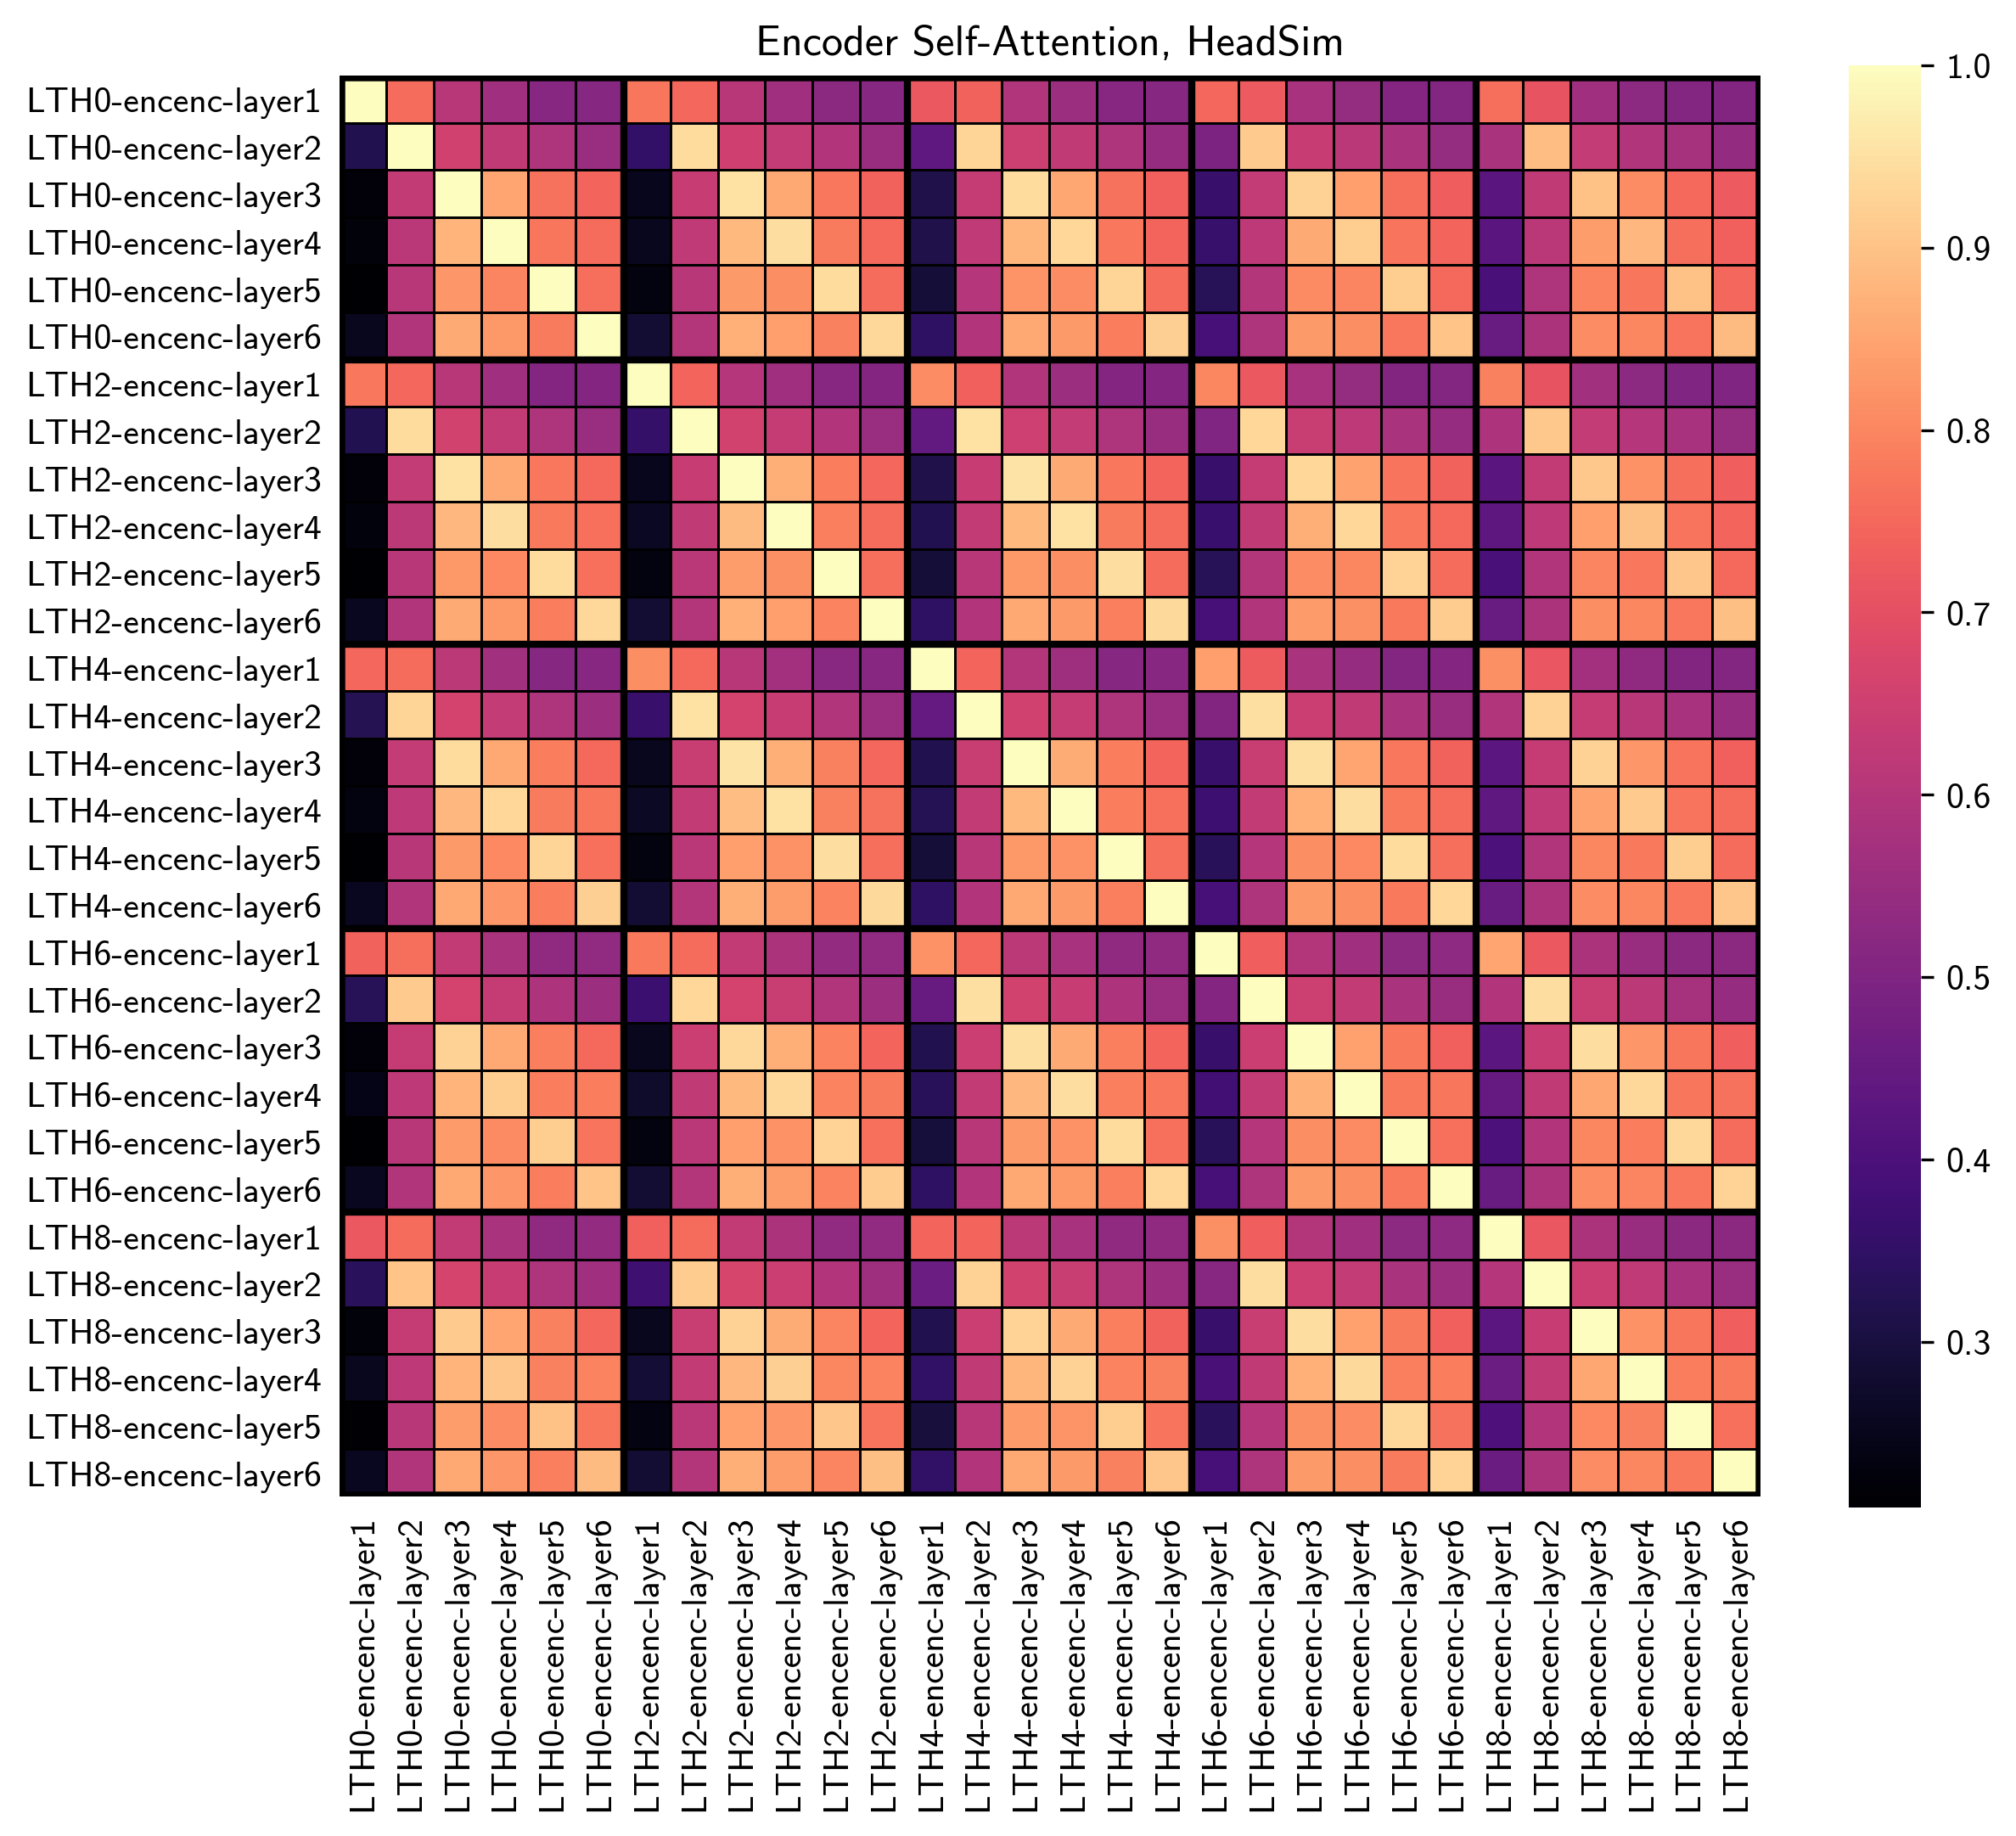

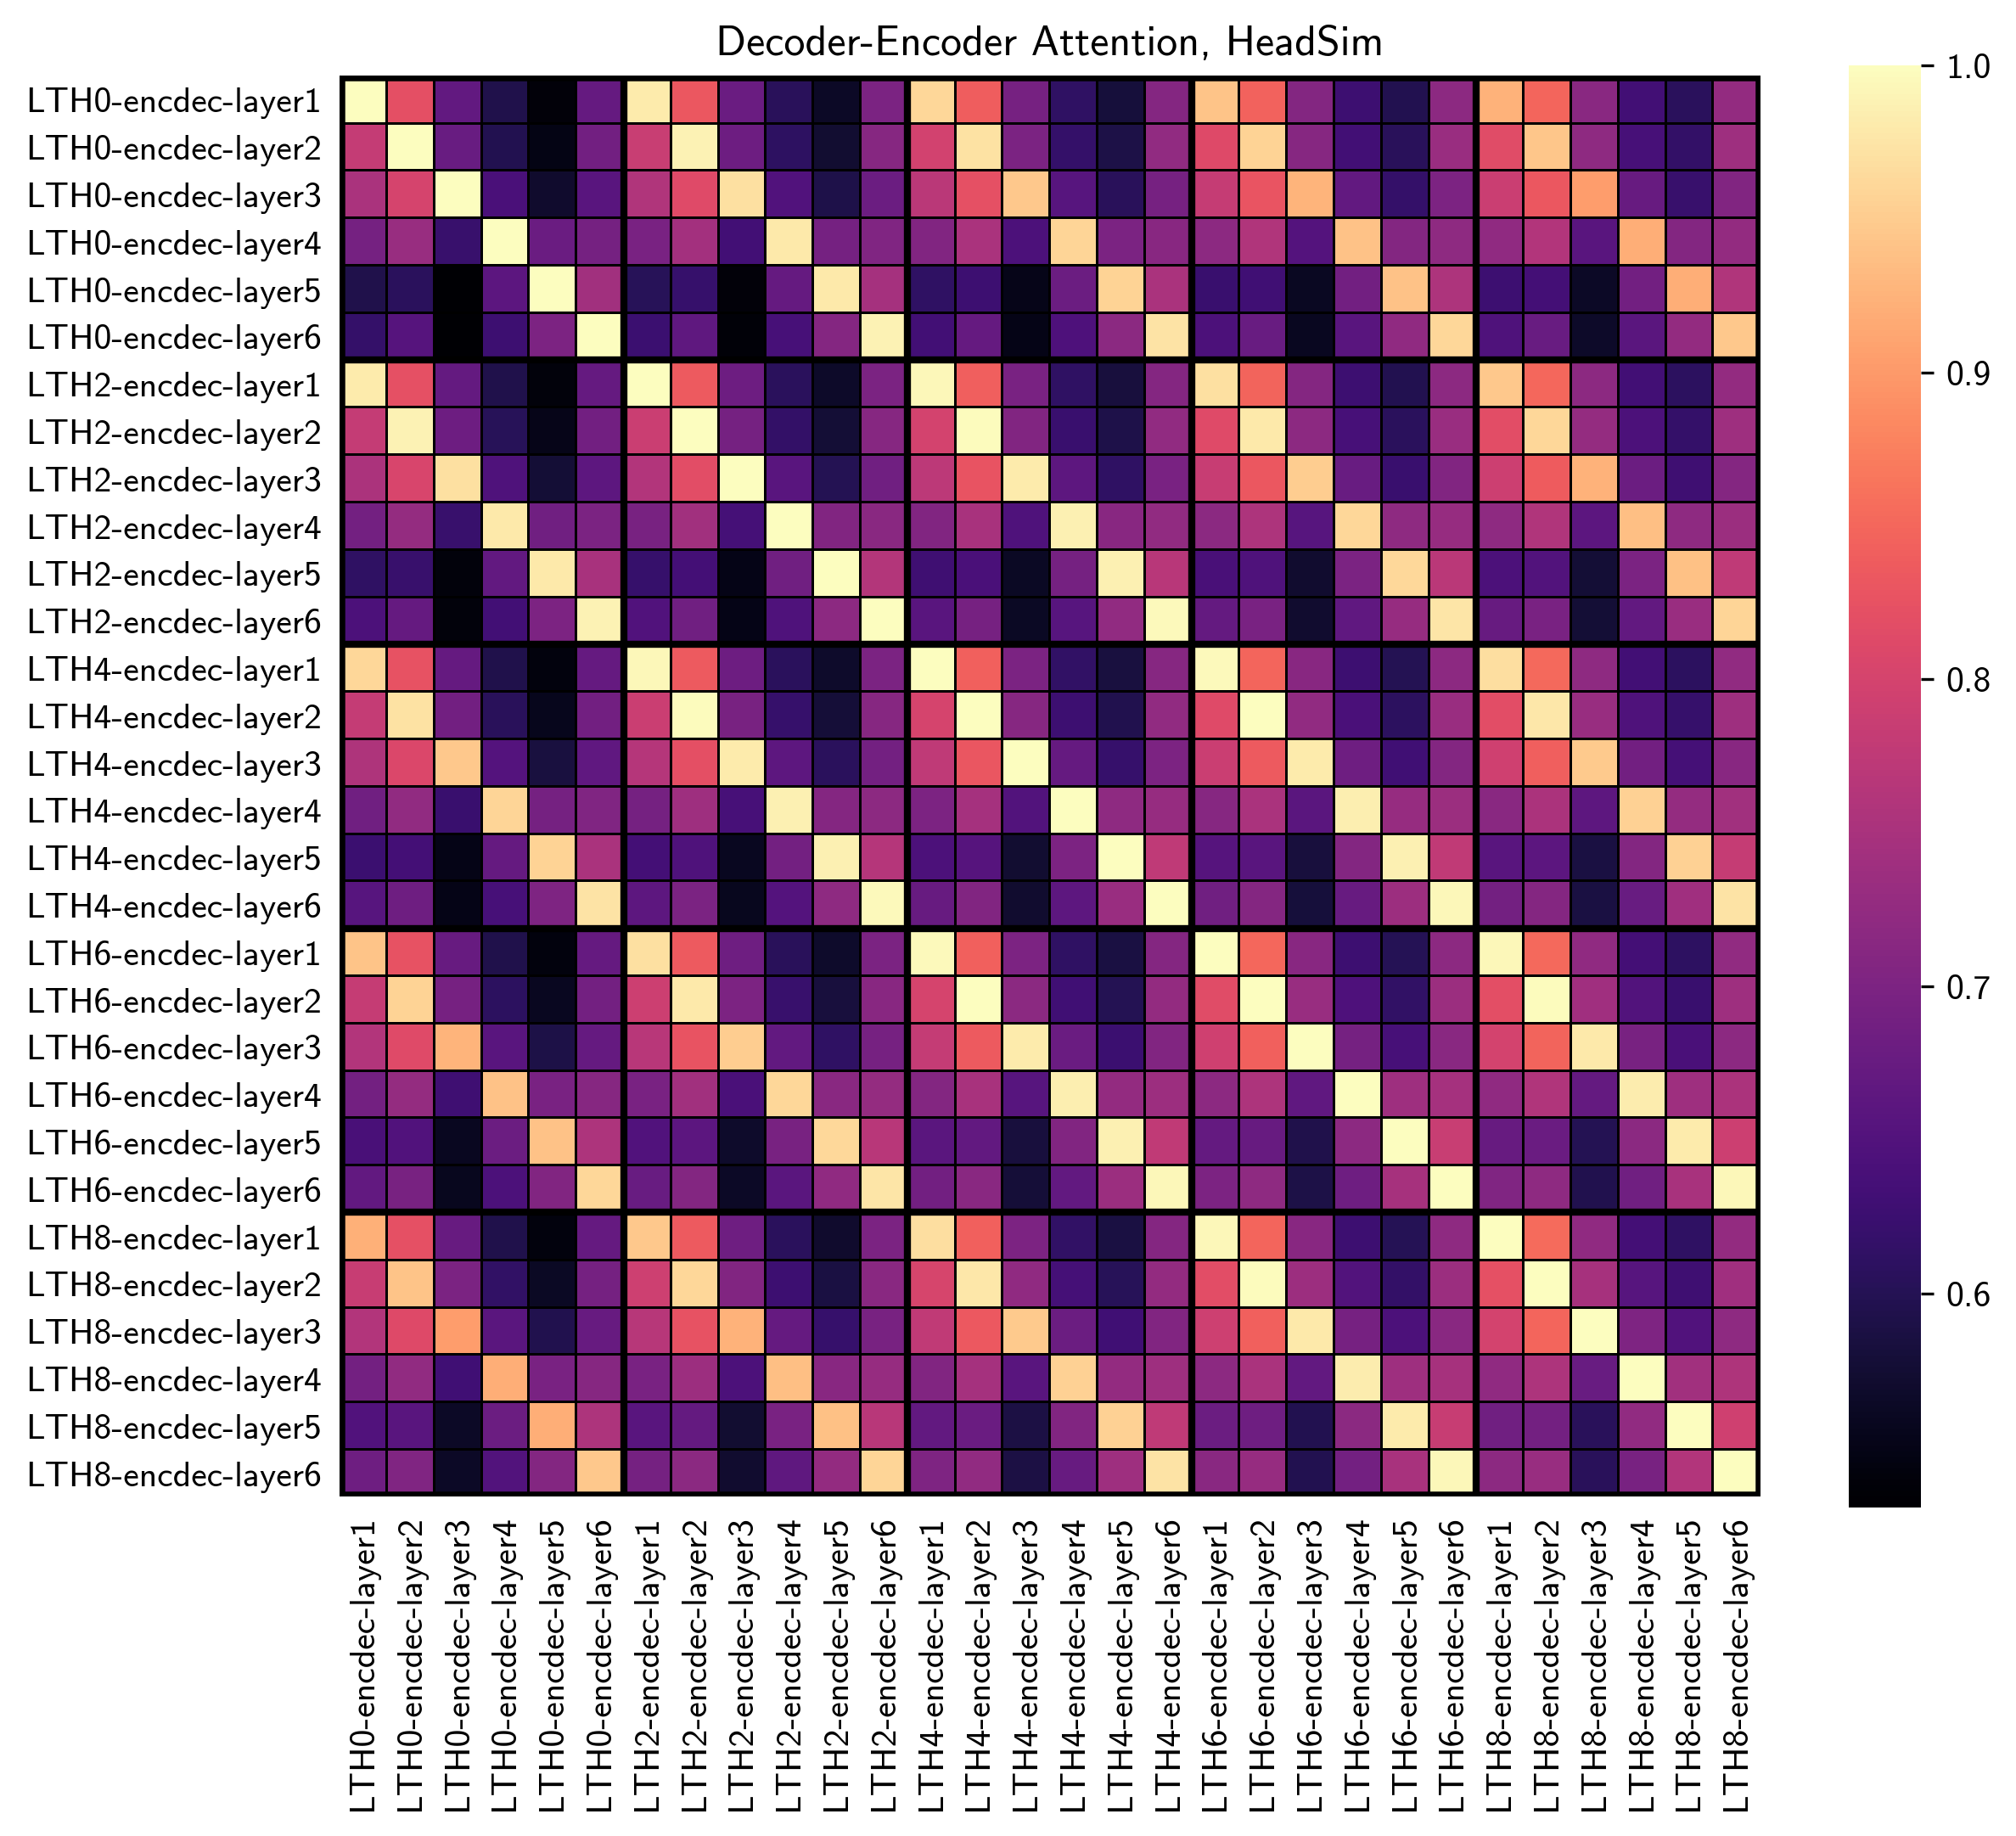

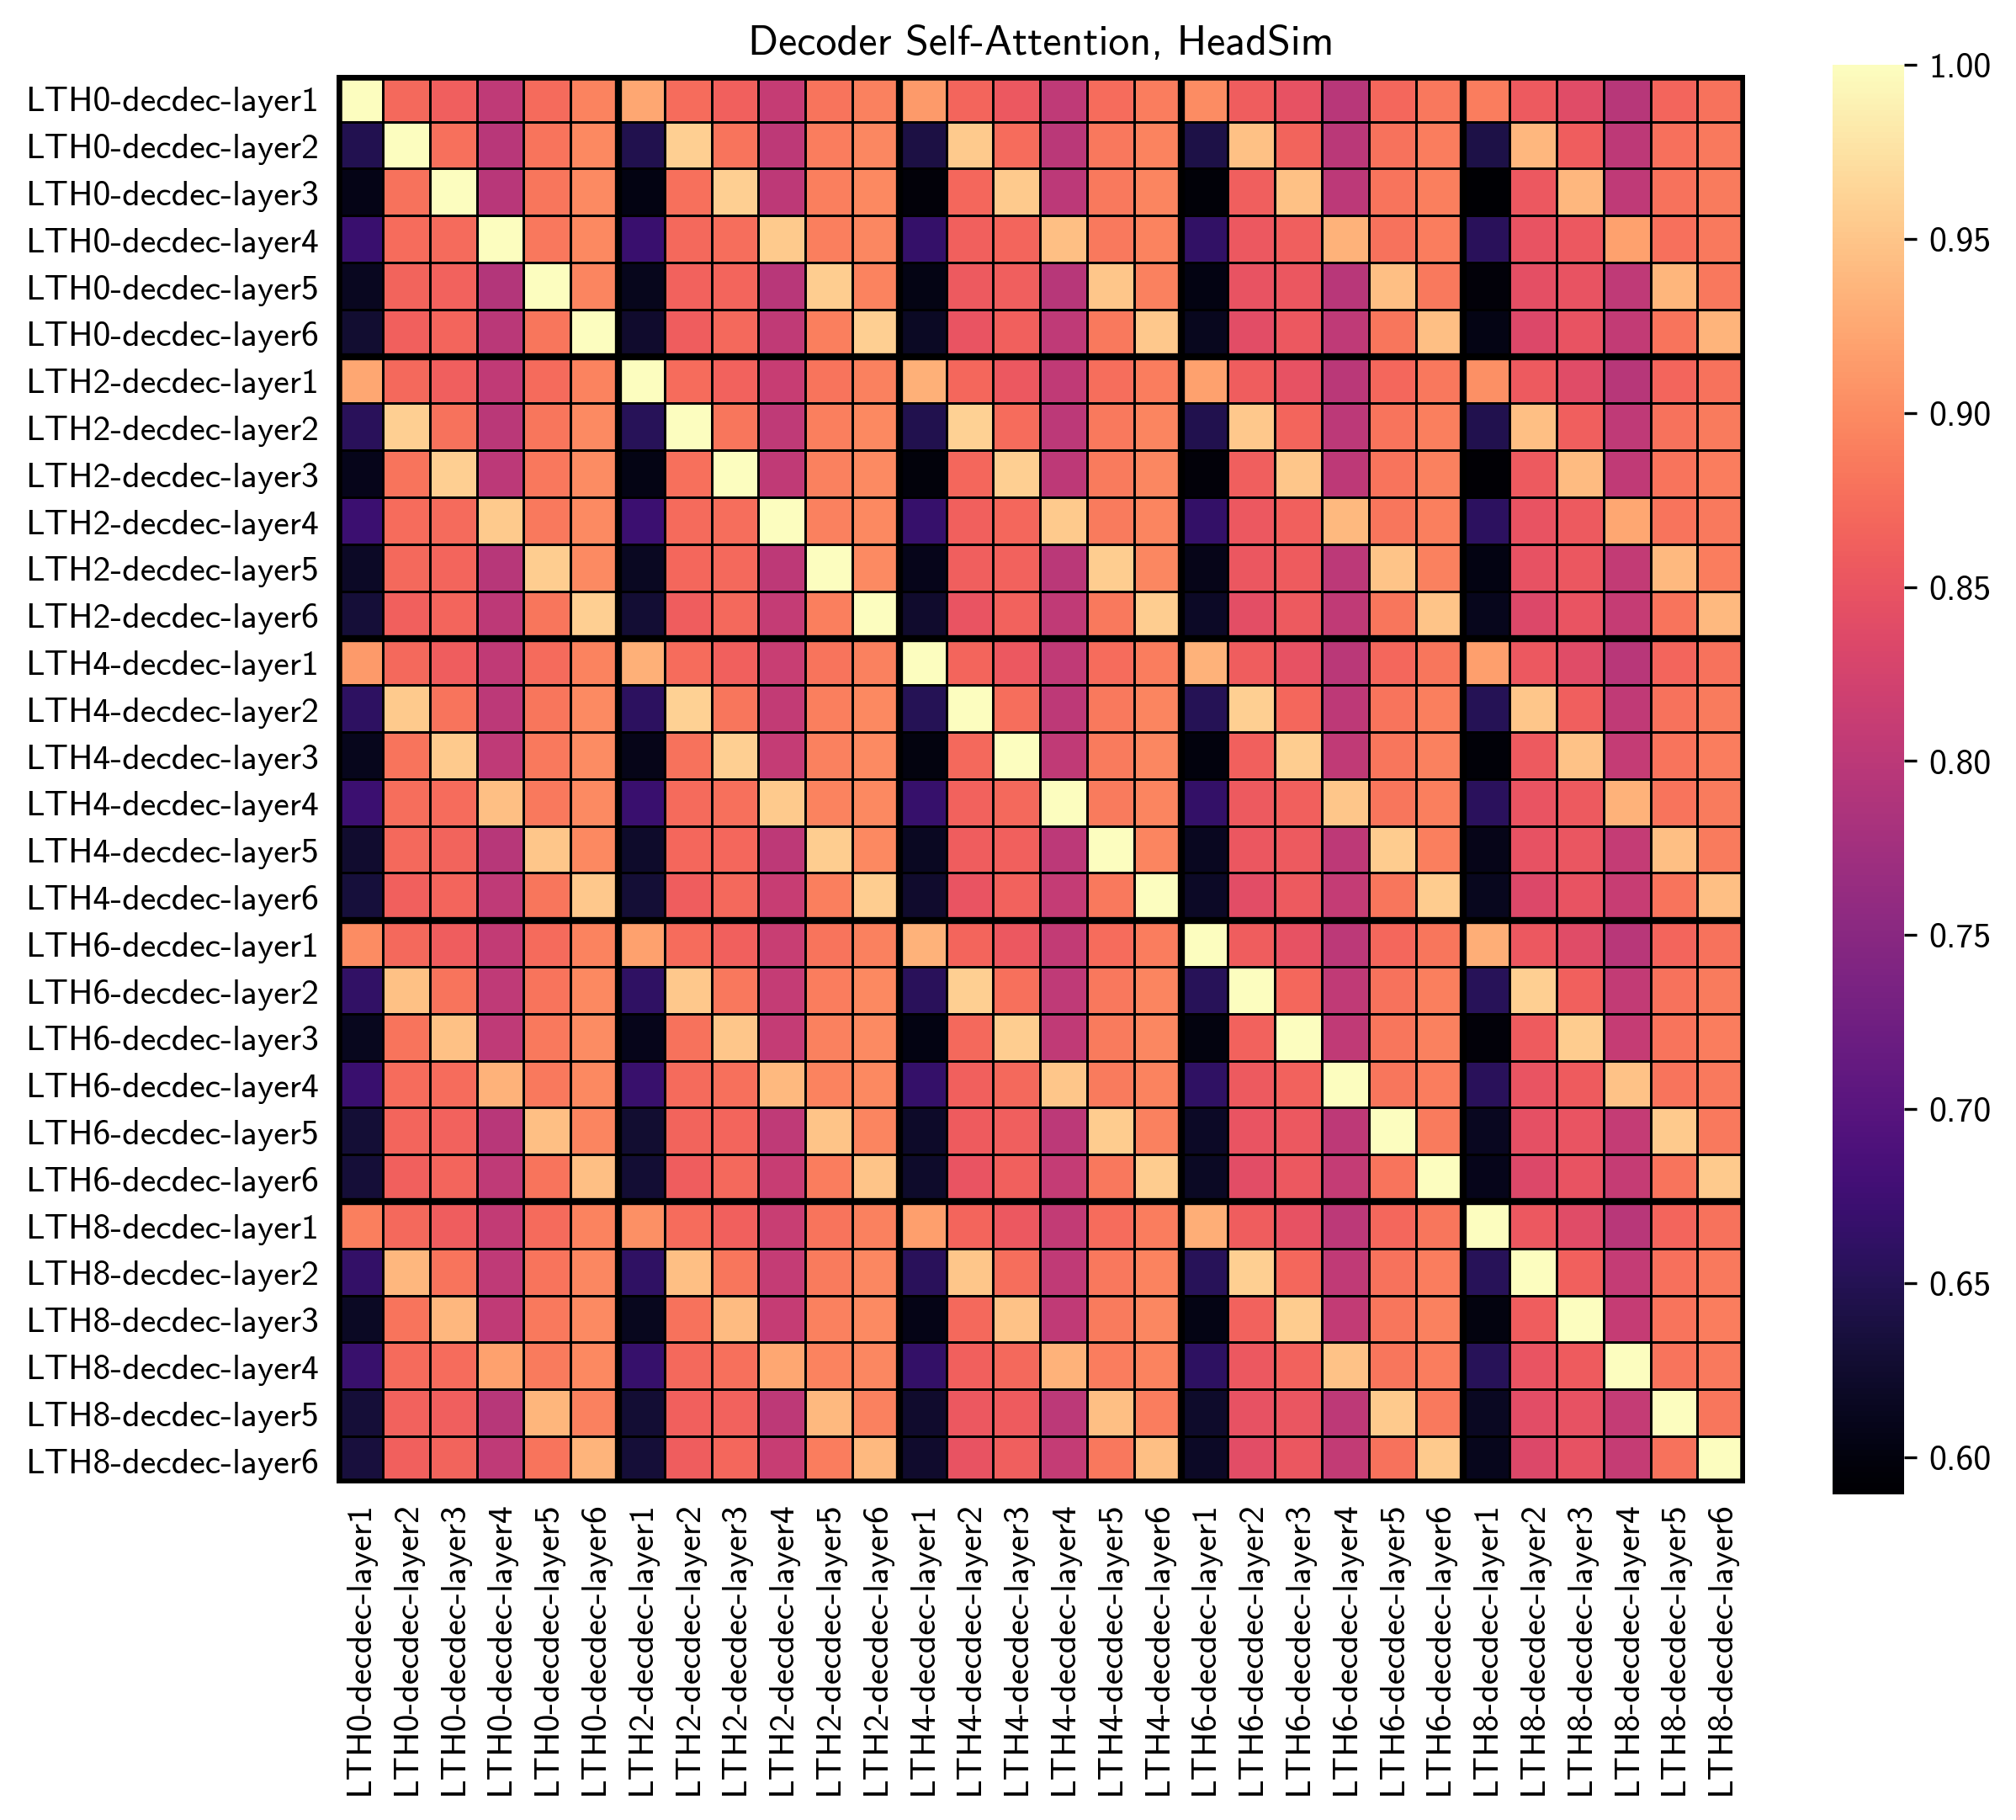

In [132]:
type_to_titles = {'encenc': 'Encoder Self-Attention', 
                  'encdec': 'Decoder-Encoder Attention',
                  'decdec': 'Decoder Self-Attention'
                 }

for attntype in attnsim:
    corr_df = pd.DataFrame(attnsim[attntype]['pearsonmaxcorr'])
    use_models = ['LTH0', 'LTH2', 'LTH4', 'LTH6', 'LTH8']
    use_cols = [col.split('-')[0] in use_models for col in  corr_df.columns]
    corr_df = corr_df.iloc[use_cols, use_cols]

    plt.figure(figsize = (9, 7.5), dpi=300)
    ax = sns.heatmap(corr_df, cmap='magma', lw=0.5, linecolor='k', square=True)
    ax.tick_params(axis='both', which='both', length=0, pad=5)
    for x in range(0, len(corr_df.columns)+6, 6):
        ax.axvline(x, lw=2, color='k')
        ax.axhline(x, lw=2, color='k')
    ax.add_patch(Rectangle((0, 0), len(corr_df.columns), len(corr_df.index), fill=False, edgecolor='black', lw=3))
    ax.set_title(f"{type_to_titles[attntype]}, HeadSim, Pearson Corr")
    plt.show()

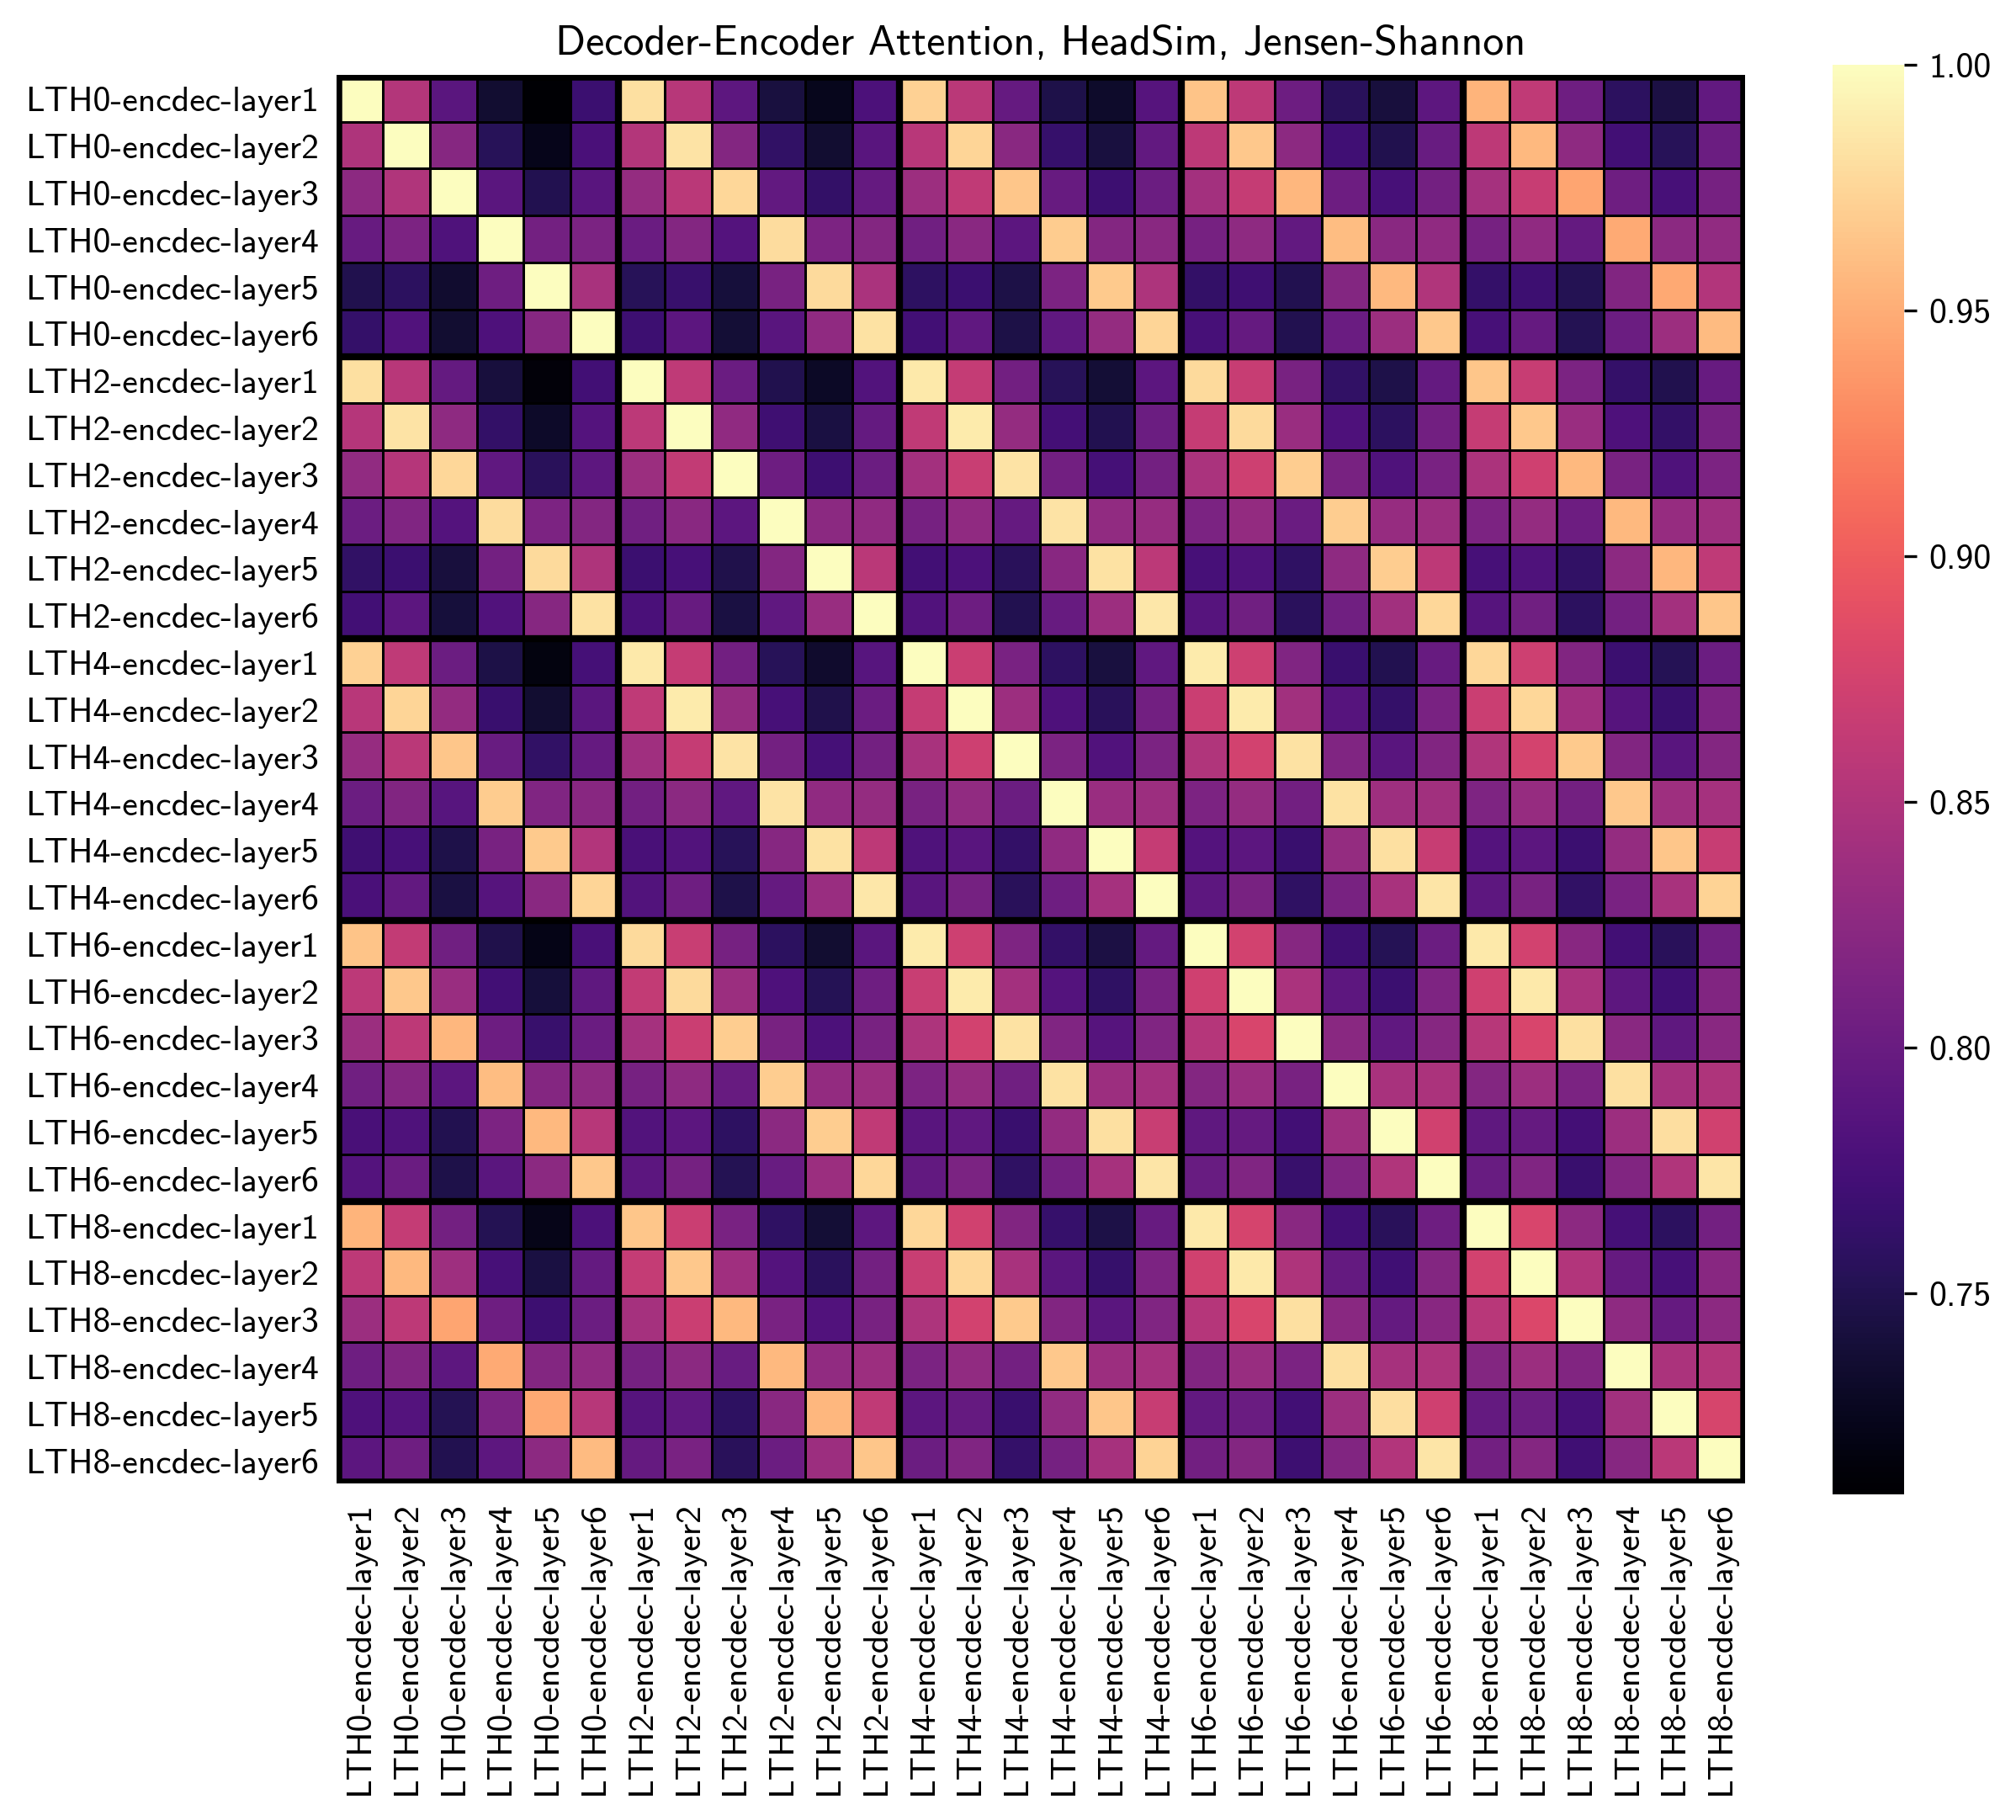

In [136]:
type_to_titles = {'encenc': 'Encoder Self-Attention', 
                  'encdec': 'Decoder-Encoder Attention',
                  'decdec': 'Decoder Self-Attention'
                 }

for attntype in attnsim:
    # jensen shannon doesn't work for enc/dec self-attn because attention maps are 'trivial', always pointing to one token only
    if attntype == 'encenc' or attntype == 'decdec':
        continue
    corr_df = pd.DataFrame(attnsim[attntype]['jsmaxcorr'])
    use_models = ['LTH0', 'LTH2', 'LTH4', 'LTH6', 'LTH8']
    use_cols = [col.split('-')[0] in use_models for col in  corr_df.columns]
    corr_df = corr_df.iloc[use_cols, use_cols]

    plt.figure(figsize = (9, 7.5), dpi=300)
    ax = sns.heatmap(corr_df, cmap='magma', lw=0.5, linecolor='k', square=True)
    ax.tick_params(axis='both', which='both', length=0, pad=5)
    for x in range(0, len(corr_df.columns)+6, 6):
        ax.axvline(x, lw=2, color='k')
        ax.axhline(x, lw=2, color='k')
    ax.add_patch(Rectangle((0, 0), len(corr_df.columns), len(corr_df.index), fill=False, edgecolor='black', lw=3))
    ax.set_title(f"{type_to_titles[attntype]}, HeadSim, Jensen-Shannon")
    plt.show()

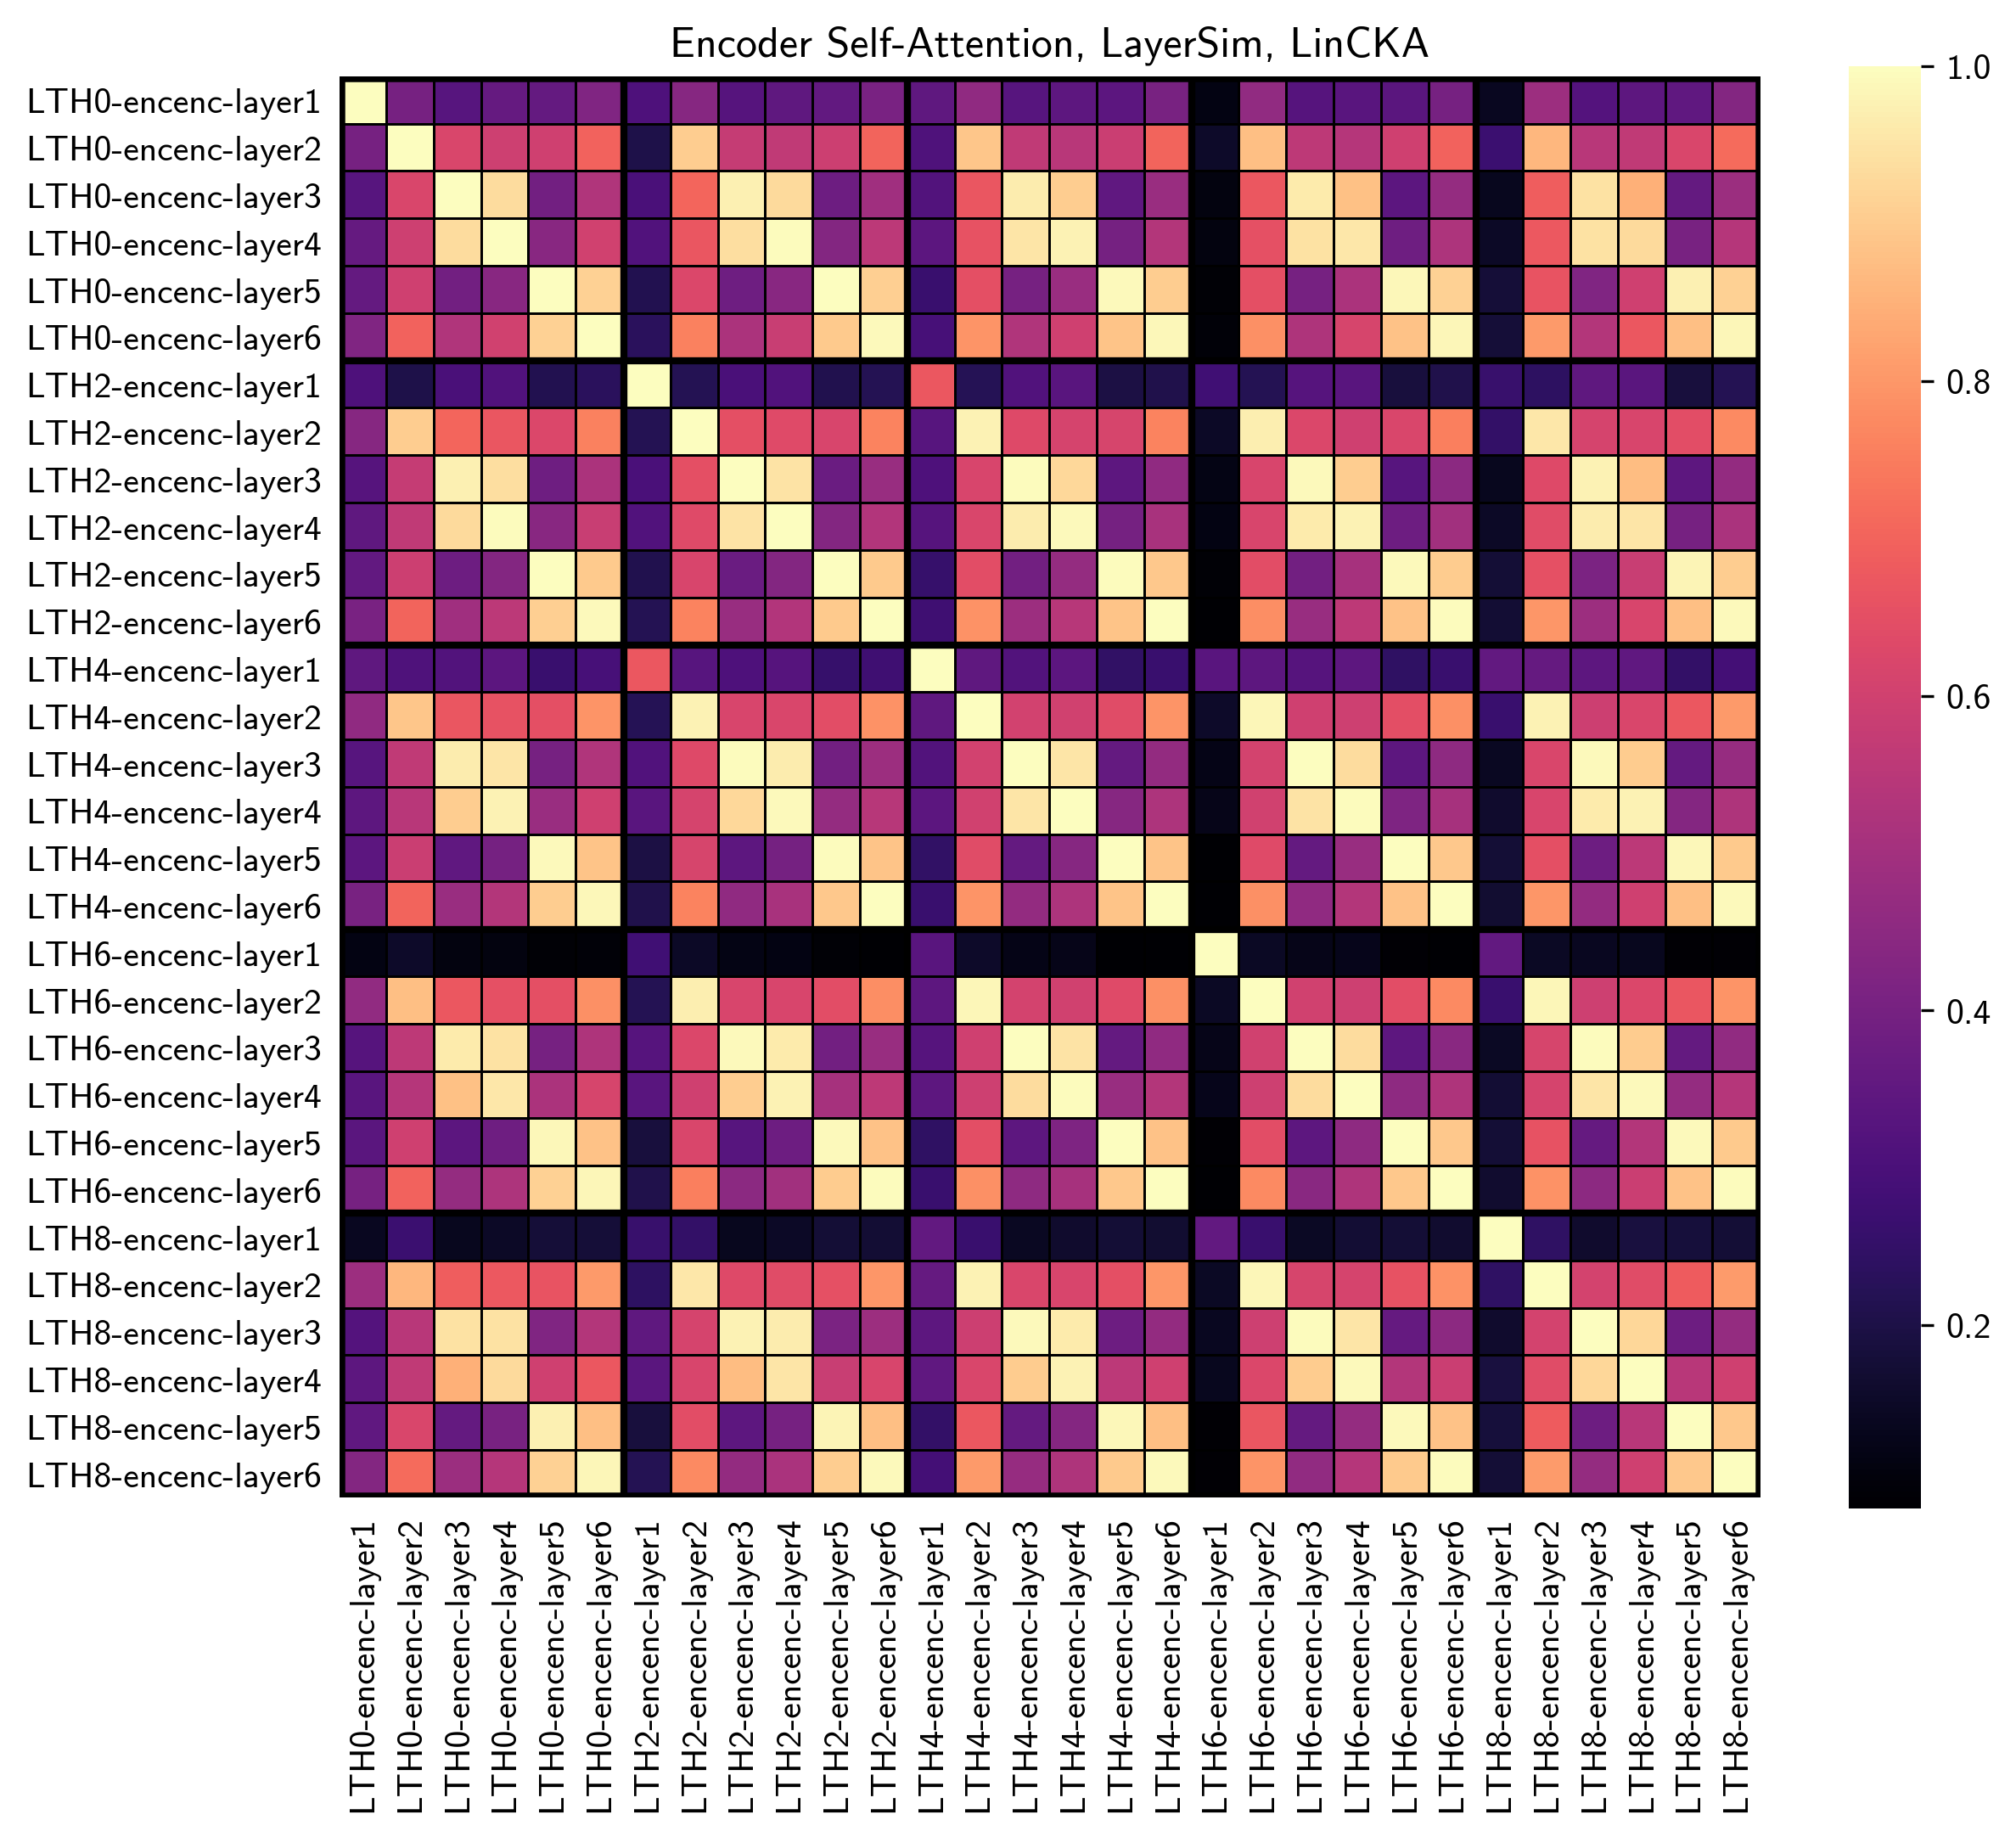

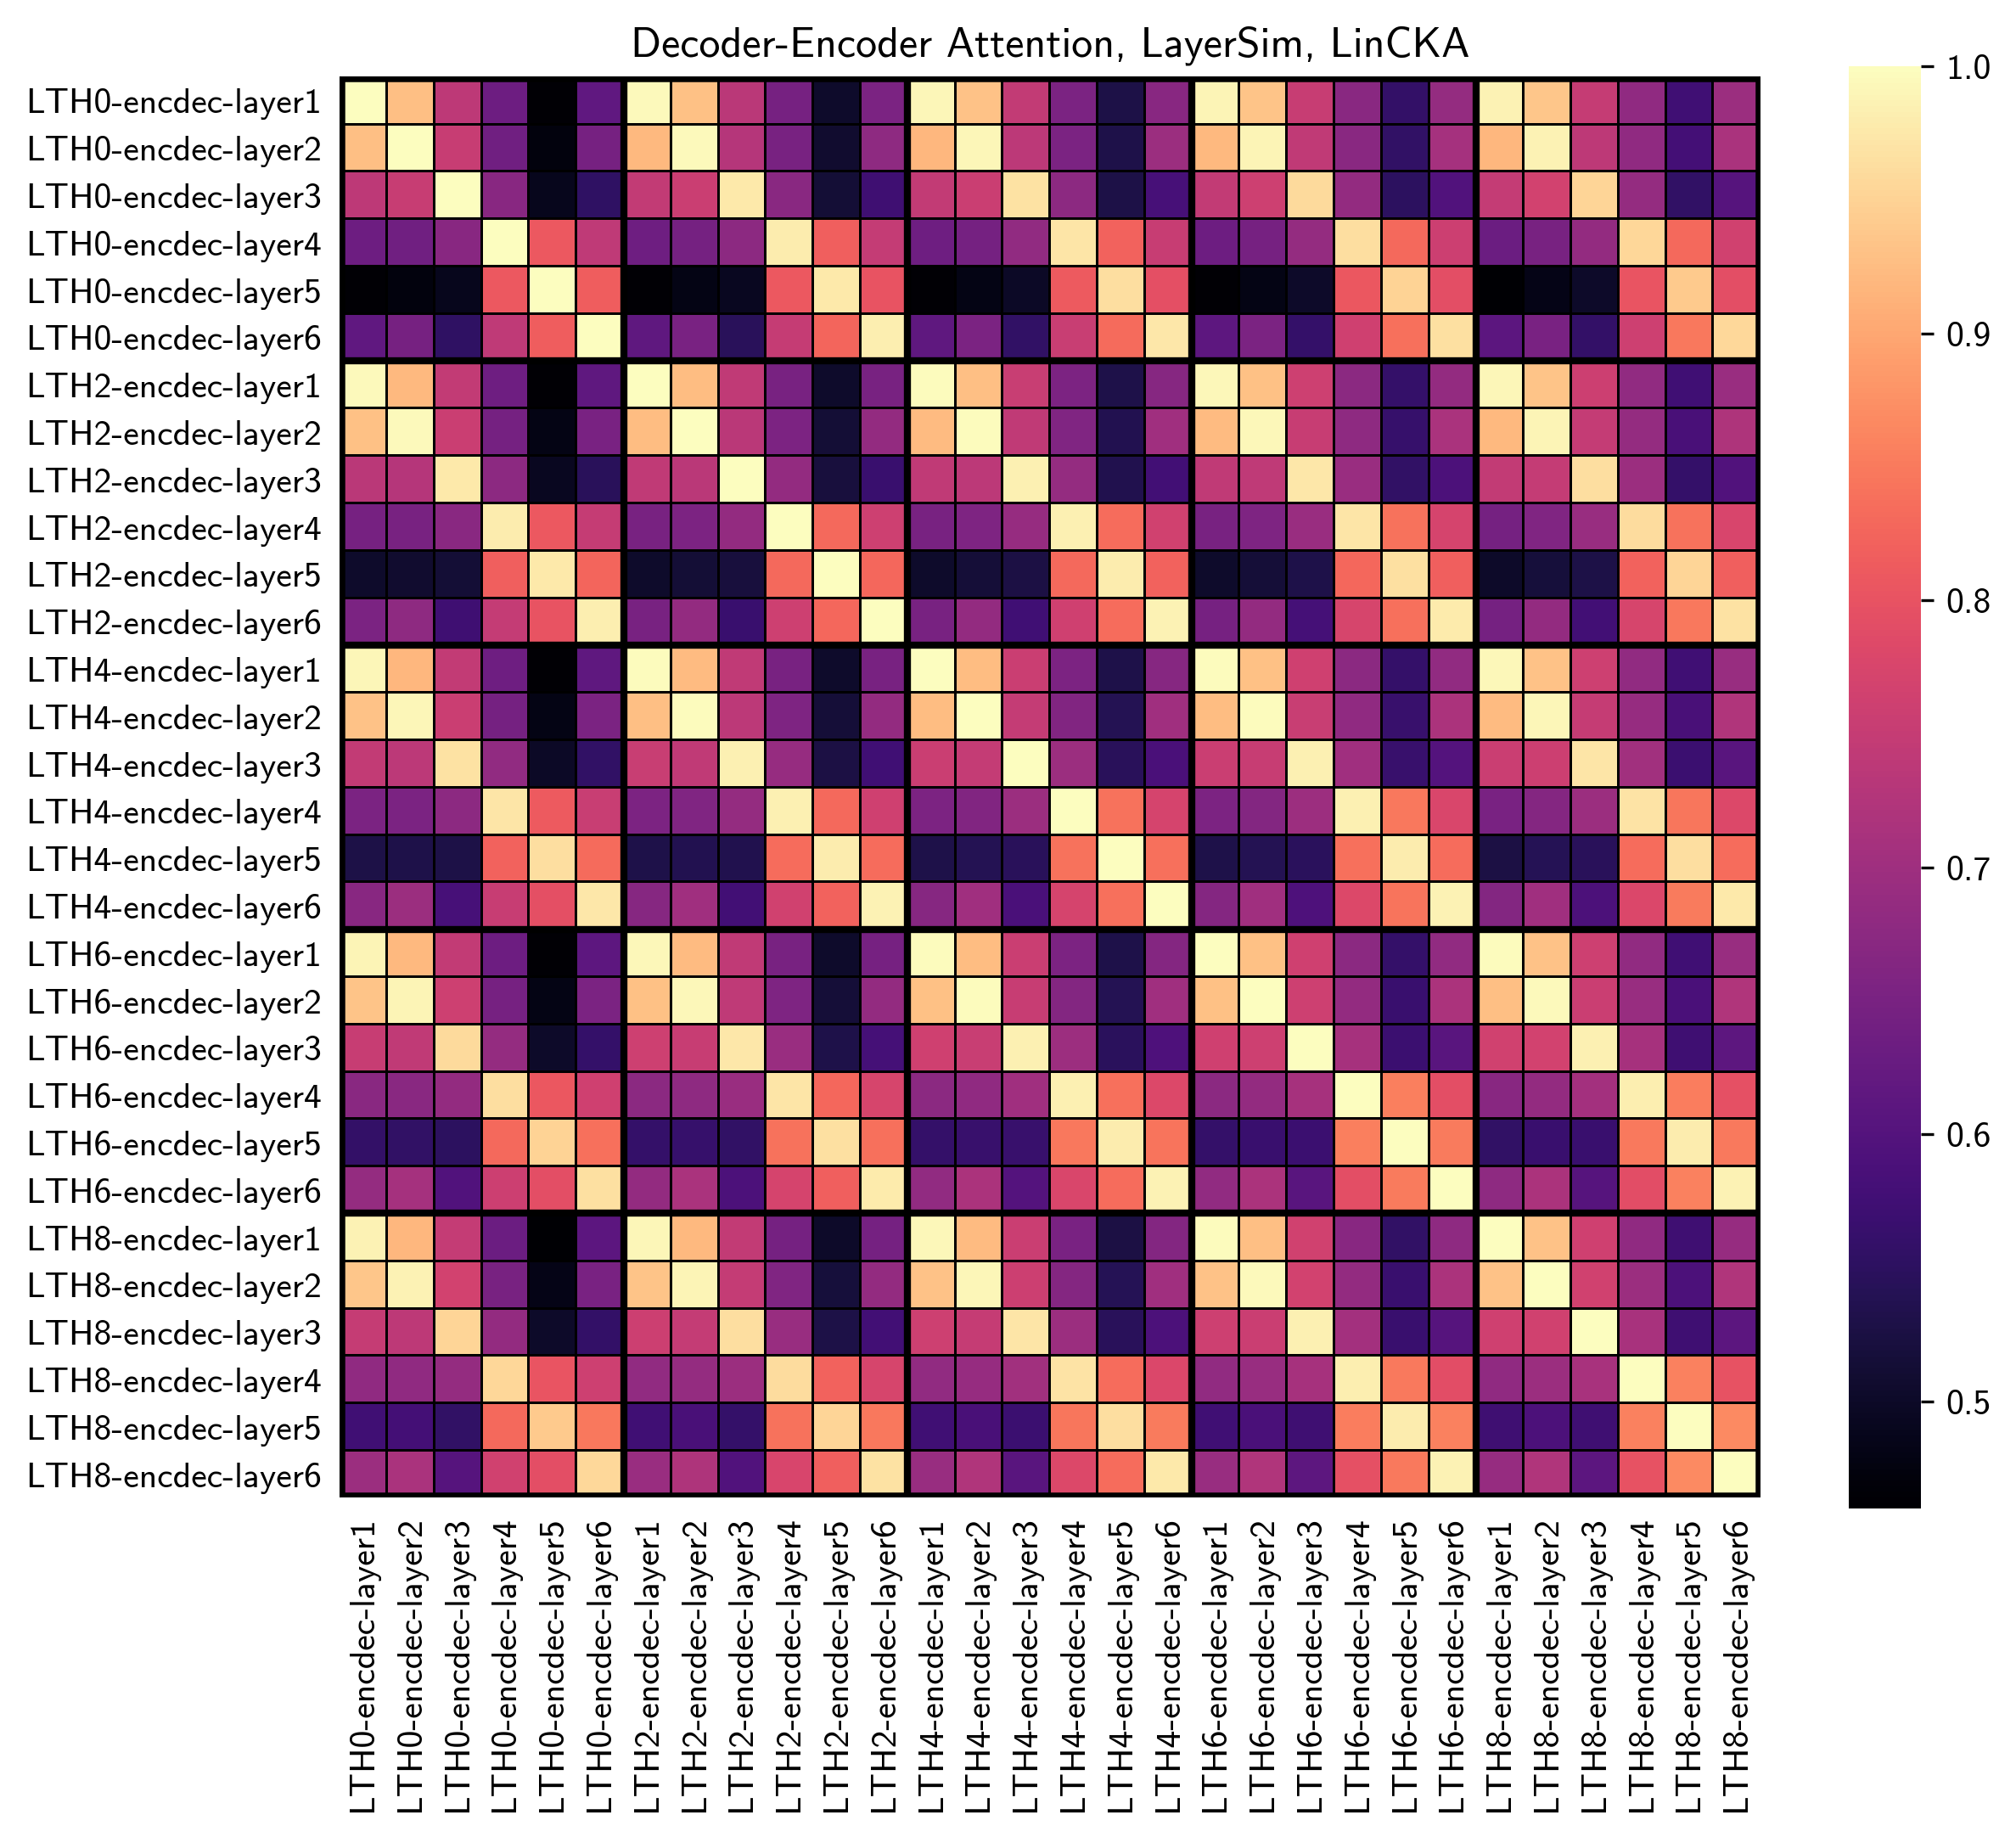

In [137]:
type_to_titles = {'encenc': 'Encoder Self-Attention', 
                  'encdec': 'Decoder-Encoder Attention',
                  'decdec': 'Decoder Self-Attention'
                 }

for attntype in attnsim:
    # for some reason lincka has an error with dec self attn
    if attntype == 'decdec':
        continue
    corr_df = pd.DataFrame(attnsim[attntype]['lincka'])
    use_models = ['LTH0', 'LTH2', 'LTH4', 'LTH6', 'LTH8']
    use_cols = [col.split('-')[0] in use_models for col in  corr_df.columns]
    corr_df = corr_df.iloc[use_cols, use_cols]

    plt.figure(figsize = (9, 7.5), dpi=300)
    ax = sns.heatmap(corr_df, cmap='magma', lw=0.5, linecolor='k', square=True)
    ax.tick_params(axis='both', which='both', length=0, pad=5)
    for x in range(0, len(corr_df.columns)+6, 6):
        ax.axvline(x, lw=2, color='k')
        ax.axhline(x, lw=2, color='k')
    ax.add_patch(Rectangle((0, 0), len(corr_df.columns), len(corr_df.index), fill=False, edgecolor='black', lw=3))
    ax.set_title(f"{type_to_titles[attntype]}, LayerSim, LinCKA")
    plt.show()